# Zweite Beschreibungsform für FIR-Tiefpassfilter
## Einleitung

In diesem Fall nutzen wir eine sequentielle Beschreibung durch einen Prozess. Ursprünglich sollten mehrere Prozesse stattfinden, aber sie haben sich zum Teil ineinander gegriffen und das Tool hat es nicht als Fehler erkannt. Bei der Simulation wurden keine Ergebnisse, bis auf 'X', angezeigt und musste neu beschrieben werden.

Es wurde ebenfalls ein anderer Fenstertyp "Kaiser, Beta = 22" verwendet. Er weist im Sperrbereich eine höhere Dämpfung (natürlich abhängig vom Beta-Koeffizienten) als der Blackmanharris. Doch die Phasenverschiebung bleibt bei beidem bleibt nahezu identisch.

In dieser Beschreibung haben wir die Symmetrie der Koeffizienten zu Nutze gemacht und nur die Hälfte verwendet. Im erstem Beispiel wurden mehrere Addiersignale in einem Array erzeugt. Bie diesem Fall wird nur ein Signal genutzt. Insgesamt ähnelt die Beschreibung sehr prozeduale Anweisungen von der allgemeinen Softwareentwicklungen.

### Hinweis

Die Werte wurden um einem bestimmten Faktor erhöht, um höhere Genauigkeiten zu erzielen. Die Zahlen befinden sich alle als Gleitkommazahlen und werden später in einer Festkommazahl umgewandelt. Dadurch dass die Werte anfangs niedrig waren, waren die Signalverläufe ungenau gewesen.

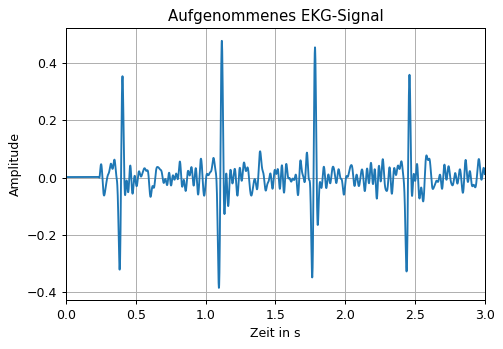

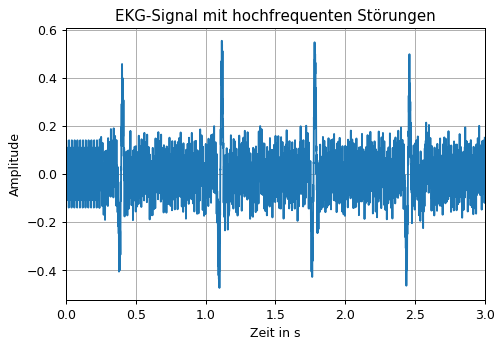

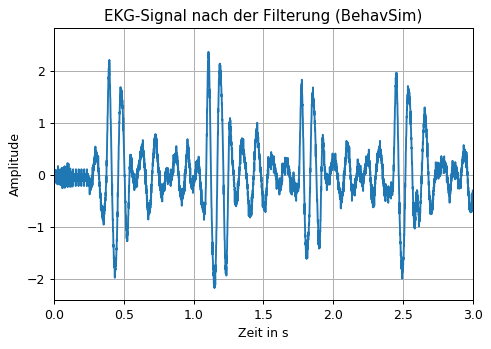

In [7]:
import matplotlib.pyplot as plt
import numpy as np

"""
    Tiefpassordnung     =            128
    Abtastfrequenz   fs =         1000Hz
    Cut-Off Frequenc fc =          140Hz
    Filtertyp           =            FIR
    Fenster             =         kaiser(beta = 22)
"""
# Zeitpunktbetrachtung
time_start = 0
time_end   = 3

# Importiere zweite Spalte aus der Textdatei und erzeuge Zeitschritte in dt = 1 ms
EKG_Signal = np.loadtxt("EKG_aufgenommen.txt", usecols = 1)
time = np.arange(len(EKG_Signal))/1000

# Frequenzen = 200Hz, 300Hz,400Hz, 450Hz
Störsignal = 0.05*np.sin(2*np.pi*200*time) + 0.05*np.sin(2*np.pi*300*time) + 0.05*np.sin(2*np.pi*400*time)+ 0.05*np.sin(2*np.pi*450*time)
# Überlagerung
EKG_Störsignal = EKG_Signal + Störsignal

# Darstellung aufgenommenes EKG-Signal
plt.figure(num=None, figsize=(6, 4), dpi=90, facecolor='w', edgecolor='k')
plt.plot(time, EKG_Signal)
plt.title("Aufgenommenes EKG-Signal")
plt.xlabel("Zeit in s")
plt.xlim(time_start,time_end)
plt.ylabel("Amplitude")
plt.grid(True)
#plt.savefig("Aufgenommenes EKG-Signal.png",)

# Darstellung aufgenommenes EKG-Signal + Störsignale
plt.figure(num=None, figsize=(6, 4), dpi=90, facecolor='w', edgecolor='k')
plt.plot(time, EKG_Störsignal)
plt.title("EKG-Signal mit hochfrequenten Störungen")
plt.xlabel("Zeit in s")
plt.xlim(time_start,time_end)
plt.ylabel("Amplitude")
plt.grid(True)
#plt.savefig("EKG-Signal mit hochfrequenten Störungen.png",)

# Importiere EKG-Signal, skaliere sie runter und erzeuge Zeitschritte in dt = 1ms
EKG_nach_FPGA = np.loadtxt("EKG_nach_FPGA_2.txt")
time2 = np.arange(len(EKG_nach_FPGA))/1000

# Darstellung aufgenommenes EKG-Signal nach FPGA-Simulation
plt.figure(num=None, figsize=(6, 4), dpi=90, facecolor='w', edgecolor='k')
plt.plot(time2, EKG_nach_FPGA)
plt.title("EKG-Signal nach der Filterung (BehavSim)")
plt.xlabel("Zeit in s")
plt.xlim(time_start,time_end)
plt.ylabel("Amplitude")
plt.grid(True)
#plt.savefig("EKG-Signal nach der Filterung (BehavSim).png",)

plt.show()

## Analyse der Grafiken

Man erkennt drei Grafiken:
1. Das aufgenommene EKG-Signal
2. Das EKG-Signal mit künstlichen Störfrequenzen
3. Das EKG-Signal nach der Filterung mit dem FPGA

Bei der zweiten Grafik wurden hochfrequente Störungen dazu addiert. Das Nutzsignal ist dabei noch erkennbar. 

Das EKG-Signal, nach dem FPGA, wurde durch den Filter größtenteils von den hochfrequenten Störungen gesäubert. Dennoch schein ein kleiner Restfrequenz sich darauf noch zu befinden. Um das zu analysieren, müssen wir die Fouriertransformationen verwenden.

## Fouriertransformation der Signal

Für die Fouriertransformationen wurde die Bibliothek **scipy** mit dem Packet **fftpack** importiert. Sie erlaubt uns das Frequenzspektrum der Signale genauer zu erkennen und besser zu interpretieren.

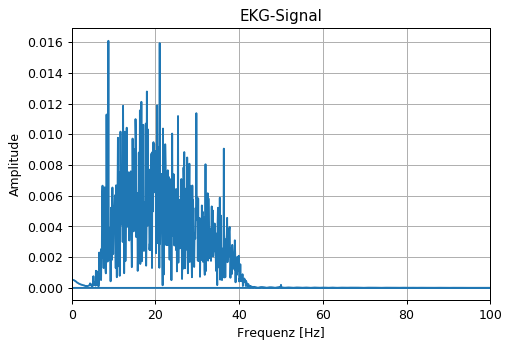

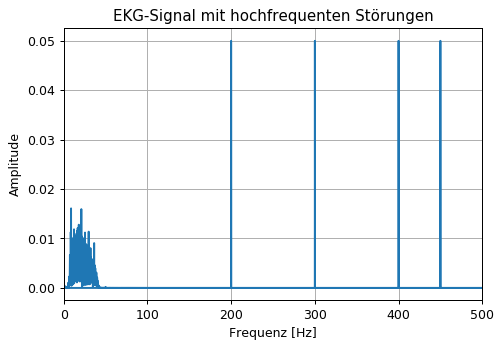

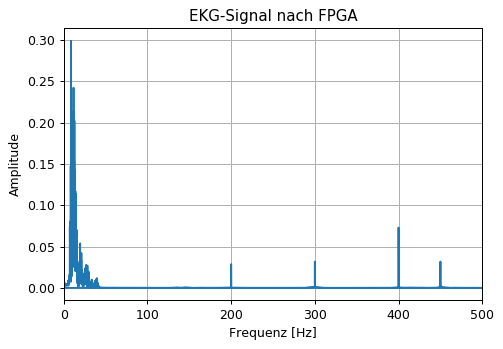

In [6]:
from scipy import fftpack

EKG_Signal_fft = fftpack.fft(EKG_Signal)
abs_ecg_signal = np.abs(EKG_Signal_fft)*2/EKG_Signal.size
sample_freq = fftpack.fftfreq(EKG_Signal.size, d=0.001)

plt.figure(num=None, figsize=(6, 4), dpi=90, facecolor='w', edgecolor='k')
plt.plot(sample_freq, abs_ecg_signal)
plt.title("EKG-Signal")
plt.xlabel('Frequenz [Hz]')
plt.xlim(0,100)
plt.ylabel('Amplitude')
plt.grid(True)

EKG_Störung_fft = fftpack.fft(EKG_Störsignal)
abs_ecg_Störung = np.abs(EKG_Störung_fft)*2/EKG_Störsignal.size
sample_freq_störung = fftpack.fftfreq(EKG_Störsignal.size, d=0.001)

plt.figure(num=None, figsize=(6, 4), dpi=90, facecolor='w', edgecolor='k')
plt.plot(sample_freq_störung, abs_ecg_Störung)
plt.title("EKG-Signal mit hochfrequenten Störungen")
plt.xlabel('Frequenz [Hz]')
plt.xlim(0,500)
plt.ylabel('Amplitude')
plt.grid(True)

EKG_nach_FPGA_fft = fftpack.fft(EKG_nach_FPGA)
abs_ecg_nach_FPGA = np.abs(EKG_nach_FPGA_fft) * 2/EKG_nach_FPGA.size
sample_freq_ecg_nach_FPGA = fftpack.fftfreq(EKG_nach_FPGA.size, d=0.001)

plt.figure(num=None, figsize=(6, 4), dpi=90, facecolor='w', edgecolor='k')
plt.plot(sample_freq_ecg_nach_FPGA, abs_ecg_nach_FPGA)
plt.title("EKG-Signal nach FPGA")
plt.xlabel('Frequenz [Hz]')
plt.xlim(0,500)
#plt.ylim(0,5000)
plt.ylabel('Amplitude')
plt.grid(True)

plt.show()

## Analyse der FFT-Grafiken

Es sind die Grafiken der FFT der Signale zu erkennen:
1. EKG-Signal
2. EKG-Signal mit hochfrequenten Störungen
3. EKG-Signal nach dem FPGA

Die künstlich hinzugefügten Frequenzen sind immernoch vorhanden, doch wesentlich stärker als zuvor gedämpft. Noch erkennbar ist, dass unser Nutzspektrum sich ebenfalls durch Berechnungen Phasenverschiebungen sich verändert hat.

## EKG-Signal mit wesentlich stärkeren Störfrequenzen

Hier wurde sogar mit wesentlich mehr Koeffizienten gearbeitet.

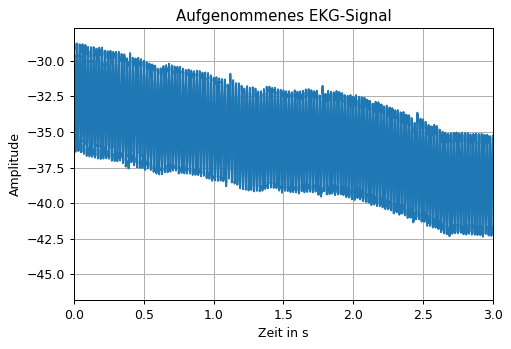

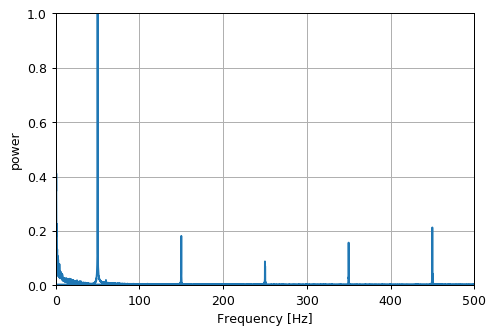

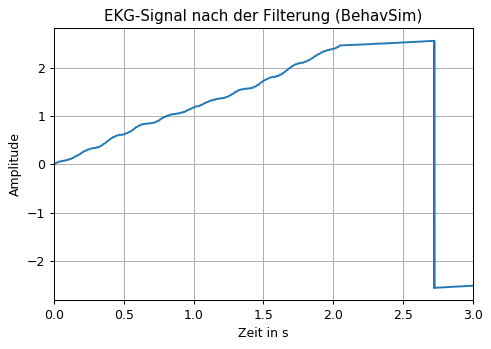

In [63]:
EKG_Signal_hard = np.loadtxt("QRS_Ungefiltert.txt", usecols = 1)
time3 = np.arange(len(EKG_Signal_hard))/1000

plt.figure(num=None, figsize=(6, 4), dpi=90, facecolor='w', edgecolor='k')
plt.plot(time, EKG_Signal_hard)
plt.title("Aufgenommenes EKG-Signal")
plt.xlabel("Zeit in s")
plt.xlim(time_start,time_end)
plt.ylabel("Amplitude")
plt.grid(True)

EKG_Signal_hard_fft = fftpack.fft(EKG_Signal_hard)
abs_EKG_Signal_hard = np.abs(EKG_Signal_hard_fft)*2/EKG_Signal_hard.size
sample_freq_EKG_Signal_hard = fftpack.fftfreq(EKG_Signal_hard.size, d=0.001)

plt.figure(num=None, figsize=(6, 4), dpi=90, facecolor='w', edgecolor='k')
plt.plot(sample_freq_EKG_Signal_hard, abs_EKG_Signal_hard)
plt.xlabel('Frequency [Hz]')
plt.xlim(0,500)
plt.ylim(0,1)
plt.ylabel('power')
plt.grid(True)


EKG_nach_FPGA_hard = np.loadtxt("EKG_nach_FPGA_hard.txt")
time4 = np.arange(len(EKG_nach_FPGA_hard))/1000

# Darstellung aufgenommenes EKG-Signal nach FPGA-Simulation
plt.figure(num=None, figsize=(6, 4), dpi=90, facecolor='w', edgecolor='k')
plt.plot(time4, EKG_nach_FPGA_hard)
plt.title("EKG-Signal nach der Filterung (BehavSim)")
plt.xlabel("Zeit in s")
plt.xlim(time_start,time_end)
plt.ylabel("Amplitude")
plt.grid(True)
#plt.savefig("EKG-Signal nach der Filterung (BehavSim).png",)

plt.show()

## Filterung mit einen aggressiveren Datensatz

Bei der Analyse des EKG-Signal mit der FFT ist da aufgefallen, dass die Störsignale im Vergleich sehr stark vom Nutzsignal abweichen. Besonders hervor stechen die 50 Hz und die unter 2 Hz. Wenn man bei 0 Hz anschaut, erkennt man dass der Wert bei ca. 80 liegt.

In [79]:
np.max(abs_EKG_Signal_hard)

79.88027066725046

Wenn der Wert jetzt entnommen wird und nochmal nach dem Maximum gesucht, dann komm ca. 3.2 raus. Das ist unser 50 Hz Wechselspannung, die sich in das System mit eingliedert

In [80]:
np.max(abs_EKG_Signal_hard[1:])

3.1933145280658475

Die Schlussfolgerung vorerst lautet, dass dieser FIR-Filter nicht ausreicht für Filterung vom den Störungen, da deren Dämpfung mit wenig Koeffizienten nicht stark beträgt. Das Ziel beträgt noch, dass wir ressourcenarm wie möglich arbeiten.